# 1. Data preparation
This notebook 
* downloads the used CML datasets [OpenMRG (Andersson et al. 2022)]() and [OpenRainER (Covi&Roversi 2023)](https://zenodo.org/records/10610886)
* transform the into a common data format  
* shows some statisitcs and comparisons of the CML and reference data

As result, the cml datasets are ready for processing and the reference data from gauges and radar are already in their final resolution of 15 minutes for evaluation. Radar rainfall along the CML paths is computed and CML-rain gauges pairs within a distance of 2km are selected.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml
import glob as glob
import pandas as pd
import poligrain as plg
import pyproj
import gzip, tarfile
import zipfile
import shutil
import os

## 1.1 OpenMRG

#### Download OpenMRG dataset with code from [OepnSense sandbox](link) and transform to the data format standards given in [Fencl et al. 2023](https://open-research-europe.ec.europa.eu/articles/3-169).

In [2]:
# function from OpenSense sandbox 
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [3]:
# function from OpenSense sandbox
ds_cml = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        "2015-06-01",
        None,
    ),  
    restructure_data=True,
)

c:\Users\Utente\Documents\radar_adjustment_intercomparison\opensense_data_downloader_and_transformer.py:301: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


#### Merge city and smhi gauges with 15 min aggregation as a wet-dry classification reference

In [4]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

In [5]:
ds_gauges_city_org = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        longitude=(["id"], df_gauges_city_metadata.Longitude_DecDeg),
        latitude=(["id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["id"], df_gauges_city_metadata.Location),
        type=(["id"], df_gauges_city_metadata.Type),
        quantization=(["id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
ds_gauges_city = ds_gauges_city_org.resample(time="15min", label="right").sum()

In [6]:
df_gauge_smhi = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)


ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        id=["SMHI"],
        time=df_gauge_smhi.index.values,
        longitude=(["id"], [11.9924]),
        latitude=(["id"], [57.7156]),
        location=(["id"], ["Goeteburg A"]),
        type=(["id"], ["15 min rainfall sum"]),
        quantization=(["id"], [0.1]),
    ),
)

In [7]:
ds_gauges_city.to_netcdf('data/andersson_2022_OpenMRG/gauges/openmrg_gauges_city.nc')
ds_gauges_smhi.to_netcdf('data/andersson_2022_OpenMRG/gauges/openmrg_gauges_smhi.nc')

In [8]:
ds_gauges = xr.concat([ds_gauges_city, ds_gauges_smhi], dim="id")
ds_gauges = ds_gauges.sel(time=slice(ds_cml.time.min(),ds_cml.time.max()))

#### Calculate distance between city rain gauges and CML center points and compute closest neighbors

In [9]:
# Project coordinates for rain gauges
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cml.coords["site_0_x"],
    ds_cml.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_0_lon, ds_cml.site_0_lat, "EPSG:25832"
)
(
    ds_cml.coords["site_1_x"],
    ds_cml.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_1_lon, ds_cml.site_1_lat, "EPSG:25832"
)

In [10]:
ds_gauges=ds_gauges.reindex(time=pd.date_range(
    "2015-06-01T00:00:00",
    "2015-08-31T23:45:00",freq="15min"), fill_value=np.nan)


In [11]:
ds_gauges.to_netcdf('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')

In [12]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cml, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=1
)

In [13]:
# remove all cml - gauge pairs that are not within 2 km
closest_neigbors = closest_neigbors.where(closest_neigbors.neighbor_id != None,drop=True)

#### Each CML gets the wet-dry time series of the nearest rain gauge as reference
Using the 1 min city gauge data results in too many individual rain events. I tried different paddings and the 15 minute aggregation looked good in several time series. This means that the SMHI rain gauge can be used analog. 

In [14]:
# getting the rain gauge time series from the nearest rain gauge for each CML (within 2 km)
reference_15min = (
    xr.full_like(ds_cml.rsl, fill_value=np.nan)
    .resample(time="15min")
    .first()
    .where(ds_gauges.time.dt.month.isin([6, 7, 8]), drop=True)
)

In [15]:
for cmlid in tqdm(closest_neigbors.cml_id):
    tmp_ga_rain = ds_gauges.sel(time=reference_15min.time).sel(id=closest_neigbors.sel(cml_id=cmlid).neighbor_id.values).rainfall_amount.values.flatten()
    tmp_ga_rain = np.stack([tmp_ga_rain, tmp_ga_rain], axis=1)    
    
    reference_15min.loc[dict(cml_id=cmlid)][:] = tmp_ga_rain

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:00<00:00, 365.75it/s]


In [16]:
reference_15min=reference_15min.to_dataset(name="rain_gauge_rainfall")

#### Get radar along CML data

In [17]:
ds_radar = xr.open_dataset(
    "data/andersson_2022_OpenMRG/radar/radar.nc"
)
# get rain rates from radar reflecitivity
ds_radar["dBZ"] = 0.4 * ds_radar.data - 30
ds_radar["R"] = (10 ** (ds_radar.data / 10) / 200) ** (5 / 8)

#add lon lat grid
x_grid, y_grid = np.meshgrid(ds_radar.x.values, ds_radar.y.values)
transformer = pyproj.Transformer.from_crs(
    "+proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90",
    "EPSG:4326",
    always_xy=True,
)
lon_grid, lat_grid = transformer.transform(xx=x_grid, yy=y_grid)

ds_radar.coords["lon"] = (("y", "x"), lon_grid)
ds_radar.coords["lat"] = (("y", "x"), lat_grid)

In [18]:
# saving radar
ds_radar.to_netcdf('data/andersson_2022_OpenMRG/radar/openmrg_rad.nc') 

In [19]:
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cml.site_0_lon.values,
    y1_line=ds_cml.site_0_lat.values,
    x2_line=ds_cml.site_1_lon.values,
    y2_line=ds_cml.site_1_lat.values,
    cml_id=ds_cml.cml_id.values,
    x_grid=ds_radar.lon.values,
    y_grid=ds_radar.lat.values,
    grid_point_location='center',
)
da_radar_along_cmls = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_radar.R,
    intersect_weights=da_intersect_weights,
)

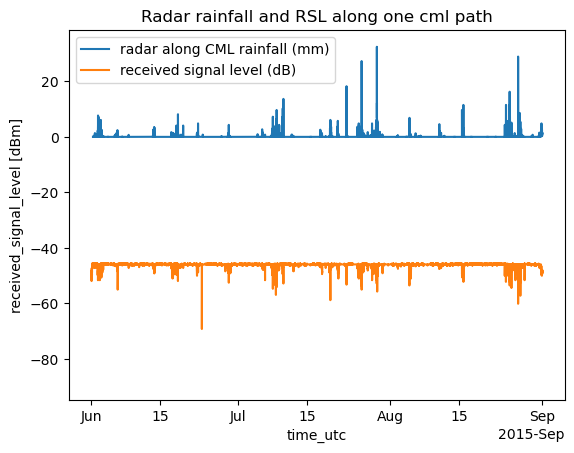

In [20]:
# radar rainfall along one cml path
da_radar_along_cmls.sel(cml_id=10001).plot(label='radar along CML rainfall (mm)')
ds_cml.rsl.sel(cml_id=10001,sublink_id='sublink_1').plot(label='received signal level (dB)')
plt.legend()
plt.title('Radar rainfall and RSL along one cml path');

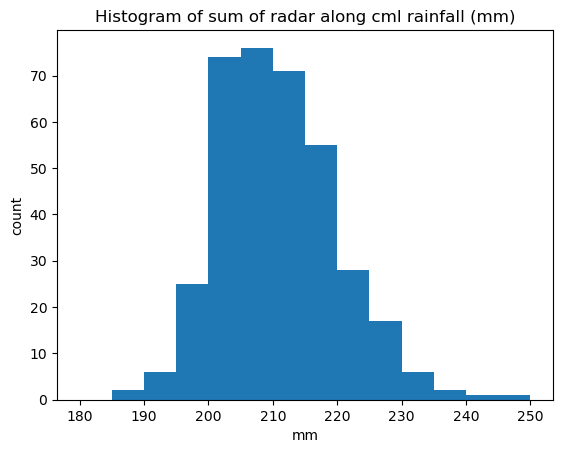

In [21]:
(da_radar_along_cmls.sum(dim='time')/12).plot.hist(bins=np.linspace(180,250,15))
plt.xlabel('mm')
plt.ylabel('count')
plt.title('Histogram of sum of radar along cml rainfall (mm)');

In [22]:
# save radar along cml data
ds_radar_along_cmls=da_radar_along_cmls.to_dataset(name='rainfall_amount')
ds_radar_along_cmls.to_netcdf('data/andersson_2022_OpenMRG/radar/radar_along_cml.nc')

In [23]:
# resample to 15 min 
ds_radar_along = ds_radar_along_cmls.resample(time='15min').sum().sel(time=reference_15min.time)/4

In [24]:
# sort by cml_id before combining into one dataset
reference_15min = reference_15min.sortby(reference_15min.cml_id)
ds_radar_along =  ds_radar_along.sortby(ds_radar_along.cml_id)

In [25]:
# add radar_along_cml to reference dataset
reference_15min['radar_along_cml'] = xr.full_like(reference_15min.rain_gauge_rainfall,fill_value=np.nan)

reference_15min['radar_along_cml'].loc[dict(sublink_id='sublink_1')]=ds_radar_along.rainfall_amount
reference_15min['radar_along_cml'].loc[dict(sublink_id='sublink_2')]=ds_radar_along.rainfall_amount

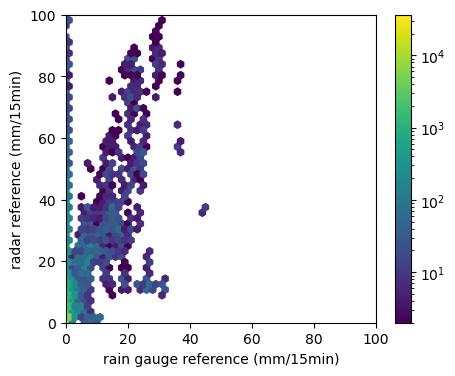

In [26]:
plt.subplots(figsize=(5,4))
plt.hexbin(
    reference_15min.rain_gauge_rainfall.resample(time='1d').sum().values.flatten(),
    reference_15min.radar_along_cml.resample(time='1d').sum().values.flatten(),
    mincnt=1,bins='log',gridsize=50,extent=[0,100,0,100])
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('rain gauge reference (mm/15min)')
plt.ylabel('radar reference (mm/15min)')
plt.colorbar();

In [27]:
# save CML file with right formatting
ds_cml.to_netcdf('data/andersson_2022_OpenMRG/openMRG_cml.nc')
# save reference file
reference_15min.to_netcdf('data/andersson_2022_OpenMRG/radar_gauge_15min_reference.nc')

## 1.2 Download OpenRainER dataset and prepare files with month with liqiud rain only

In [28]:
# storing to external datasource as this is big due to the radar ref
oddt.download_data_file(
    url="https://zenodo.org/api/records/14731404/files-archive",
    local_path="/bg/data/CML/data/other_data/OpenRainER/", 
    local_file_name='files-archive.zip', print_output=True
)

File already exists at desired location /bg/data/CML/data/other_data/OpenRainER/files-archive.zip
Not downloading!


In [29]:
dir = '/bg/data/CML/data/other_data/OpenRainER/'

In [30]:
# unzip files
with zipfile.ZipFile(dir+'files-archive.zip') as zfile:
    zfile.extractall(dir)

In [31]:
#untar dowloaded files
for tar_filename in os.listdir(dir):
    if tar_filename.endswith('.tar'):
        tar_path = os.path.join(dir, tar_filename)
        
        # Estrazione del file .tar
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(dir)  # Estrai tutto nella stessa directory

C:\Users\Utente\AppData\Local\Temp\ipykernel_16616\51972639.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(dir)  # Estrai tutto nella stessa directory


In [32]:
# unzip through all files in the directory
for filename in os.listdir(dir):
    # Check if the file has a .gz extension | select only 2 month
    if (filename.endswith('.gz')) & (('202207' in filename) | ('202208' in filename)) :
        gz_path = os.path.join(dir, filename)
        unzipped_path = os.path.join(dir, filename[:-3])  # Remove the .gz extension
        
        # Unzip the file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Delete the original .gz file 
        os.remove(gz_path)

In [33]:
# menaging AWS

In [34]:
fns = sorted(glob.glob(dir+"/AWS_20220[7-8]*nc"))

In [35]:
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.id.values))
common_ids = list(set.intersection(*ids))

rainfall=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    tmp = tmp.sel(id=common_ids)
    rainfall.append(tmp.rainfall_amount.load())


100%|██████████| 2/2 [00:00<00:00, 59.38it/s]


In [36]:
ds_rainfall = xr.concat(rainfall,dim='time')
ds_rainfall.to_netcdf(dir+"AWS_rainfall.nc")

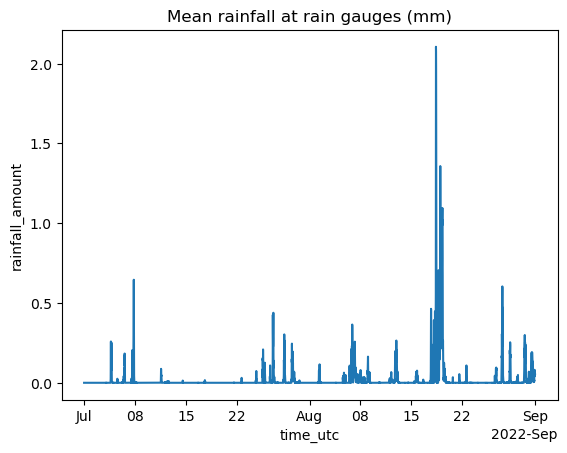

In [37]:
ds_rainfall.mean(dim='id').plot()
plt.title('Mean rainfall at rain gauges (mm)');

In [38]:
ds_rainfall.to_netcdf('data/covi_2024_OpenRainER/AWS_rainfall.nc')

#### Merge cmls to one dataset

In [39]:
fns = sorted(glob.glob(dir+"CML_20220[7-8]*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

cmls=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn) 
    tmp = tmp.sel(cml_id=common_ids)
    cmls.append(tmp.load())


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


In [40]:
ds_cmls = xr.concat(cmls,dim='time')

In [41]:
#ds_cmls['frequency'] = ds_cmls['frequency'].isel(time=1).drop_vars('time')
#ds_cmls['polarization'] = ds_cmls['polarization'].isel(time=1).drop_vars('time')

In [42]:
ds_cmls.nbytes/1e9

0.431608248

In [43]:
ds_cmls.to_netcdf("data/covi_2024_OpenRainER/OpenRainER_cmls.nc")

#### Extracting radar along CML path for each month
from raw files again as its more meory efficient..

In [44]:
dir = '/bg/data/CML/data/other_data/OpenRainER/'

fns_cml = glob.glob(dir+"/CML_20220[7-8]*")
fns_radar = glob.glob(dir+"/RADadj_20220[7-8]*")

In [45]:
len(fns_cml) == len(fns_radar)

True

In [46]:
fns = sorted(glob.glob("/bg/data/CML/data/other_data/OpenRainER/CML_20220[7-8]*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

100%|██████████| 2/2 [00:00<00:00, 53.58it/s]


In [47]:
list_radar_along_cmls=[]
list_radar=[]
count=[]
for i in tqdm(range(len(fns_cml))):
    ds_cml = xr.open_dataset(fns_cml[i]).sel(cml_id=common_ids)
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

    # calculate intersection weights
    da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
        x1_line=ds_cml.site_0_lon.values,
        y1_line=ds_cml.site_0_lat.values,
        x2_line=ds_cml.site_1_lon.values,
        y2_line=ds_cml.site_1_lat.values,
        cml_id=ds_cml.cml_id.values,
        x_grid=ds_radar.lon_grid.values,
        y_grid=ds_radar.lat_grid.values,
        grid_point_location='center',
    )
    # calculate rainfall along intersectons
    list_radar_along_cmls.append(plg.spatial.get_grid_time_series_at_intersections(
        grid_data=ds_radar.rainfall_amount,
        intersect_weights=da_intersect_weights,
    ))
    

100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


In [48]:
ds_radar = xr.concat(list_radar,dim='time')
ds_radalong = xr.concat(list_radar_along_cmls,dim='time').to_dataset(name='rainfall_amount')

In [49]:
# fill in missing time steps
ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})
ds_radalong = ds_radalong.reindex({'time':pd.date_range(ds_radalong.time.min().values,ds_radalong.time.max().values,freq='15min')})

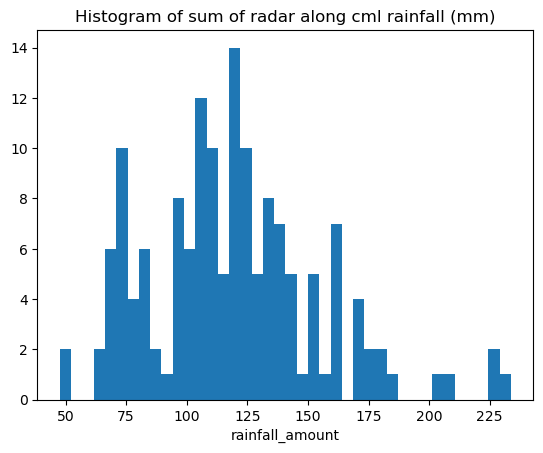

In [50]:
ds_radalong.rainfall_amount.sum(dim='time').plot.hist(bins=40)
plt.title('Histogram of sum of radar along cml rainfall (mm)');

In [51]:
# saving both radar and radar_along_cml
ds_radar.to_netcdf("data/covi_2024_OpenRainER/openrainer_radar.nc")
ds_radalong.to_netcdf("data/covi_2024_OpenRainER/RADadj_along_cml.nc")

#### Prepare data for analysis


In [52]:
ds_gauges=xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc").rainfall_amount.load()
ds_gauges=ds_gauges.where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [53]:
ds_cml=xr.open_dataset("data/covi_2024_OpenRainER/OpenRainER_cmls.nc").load()
ds_cml=ds_cml.where(ds_cml.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [54]:
ds_radar_along=xr.open_dataset("data/covi_2024_OpenRainER/RADadj_along_cml.nc").load()
ds_radar_along=ds_radar_along.where(ds_radar_along.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

#### Calculate distance between rain gauges and CMLs using [`poligrain`](https://poligrain.readthedocs.io/en/latest/index.html)

In [55]:
# Project coordinates for rain gauges
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cml.coords["site_0_x"],
    ds_cml.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_0_lon, ds_cml.site_0_lat, "EPSG:25832"
)
(
    ds_cml.coords["site_1_x"],
    ds_cml.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_1_lon, ds_cml.site_1_lat, "EPSG:25832"
)

In [56]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cml, ds_gauges, max_distance=max_distance, n_closest=1
)

In [57]:
# remove all cml - gauge pairs that are not within 2 km
closest_neigbors = closest_neigbors.where(closest_neigbors.neighbor_id != None,drop=True)

####  Perpare reference data

In [58]:
# getting the rain gauge time series from the nearest rain gauge for each CML (within 2 km)
reference_15min = xr.full_like(ds_cml.rsl, fill_value=np.nan).resample(time='15min').first().where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [59]:
for cmlid in tqdm(closest_neigbors.cml_id):
    tmp_ga_rain = (np.repeat(
        ds_gauges.sel(time=reference_15min.time).sel(id=closest_neigbors.sel(cml_id=cmlid).neighbor_id.values).values[:, np.newaxis],
        2,
        axis=1,))
    reference_15min.loc[dict(cml_id=cmlid)] = tmp_ga_rain[0]

reference_15min = reference_15min.to_dataset(name='rain_gauge_rainfall')

100%|██████████| 88/88 [00:00<00:00, 89.24it/s]


In [60]:
# sort by cml_id before combining into one dataset
reference_15min = reference_15min.sortby(reference_15min.cml_id)
ds_radar_along =  ds_radar_along.sortby(ds_radar_along.cml_id)

In [61]:
# add radar_along_cml to reference dataset
reference_15min['radar_along_cml'] = xr.full_like(reference_15min.rain_gauge_rainfall,fill_value=np.nan)

reference_15min['radar_along_cml'].loc[dict(sublink_id='channel1')]=ds_radar_along.rainfall_amount.T
reference_15min['radar_along_cml'].loc[dict(sublink_id='channel2')]=ds_radar_along.rainfall_amount.T

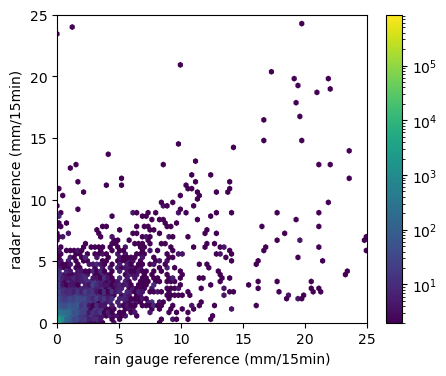

In [62]:
plt.subplots(figsize=(5,4))
plt.hexbin(
    reference_15min.rain_gauge_rainfall.values.flatten(),
    reference_15min.radar_along_cml.values.flatten(),
    mincnt=1,bins='log')
plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel('rain gauge reference (mm/15min)')
plt.ylabel('radar reference (mm/15min)')
plt.colorbar();

In [63]:
# save reference file
reference_15min.to_netcdf('data/covi_2024_OpenRainER/radar_gauge_15min_reference.nc')